# Sentiment Analysis for Hayuk


In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import re
import string
import os

In [ ]:
from sklearn.model_selection import train_test_split
from cleantext import clean

In [3]:
DATASET_PATH = os.path.join(os.getcwd(), "data", "processed", "dataset_sentiments.csv")

In [4]:
def cek_jml(list, index):
  jml = 0
  for i in list:
    if int(i)==int(index):
      jml += 1
  return jml

### Import Dataset

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive

In [5]:
dataset = pd.read_csv(DATASET_PATH, encoding='utf-8')
dataset.head()

,text,sentiment
0,"Jika makanannya tidak cukup buruk untuk Anda, ...",0
1,kesana buat Foto Booth hahahha.. parkir motor ...,1
2,"Mall sepi, pertama kali datang jam 10.30 di pa...",1
3,Akan kembali perjalanan berikutnya.,1
4,Diketahui Mal Tunjungan Plaza kembali kebakara...,0


In [6]:
dataset['text'] = dataset['text'].apply(lambda x: clean(x, no_emoji=True))

In [7]:
labels = list(dataset['sentiment'])
sentences = list(dataset['text'])
print(f"Jml Labels : {len(labels)}")
print(f"Jml Sentences : {len(sentences)}")

Jml Labels : 1358
Jml Sentences : 1358


In [8]:
print(f"Total Positive = {cek_jml(labels, 1)}")
print(f"Total Negative = {cek_jml(labels, 0)}")

Total Positive = 679
Total Negative = 679


## Dive in to Preprocess

In this section, We try to preprocess Data

In [9]:
# Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [11]:

def preprocess(sentence):
    sentence = sentence.lower().strip()
    words = sentence.split()
    temp = []
    for i in words:
        normal_string = re.sub("[^A-Z]", "", i, 0, re.IGNORECASE)
        temp.append(normal_string)
    sentence = " ".join(temp)

    return sentence

In [12]:
temp = []
for kalimat in sentences:
  removed = preprocess(kalimat)
  removed = stemmer.stem(removed)
  temp.append(removed)
sentences = temp
temp = []

In [14]:
# SPLIT DATA
train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(sentences, labels, random_state=5, train_size = .70)
train_sentences, test_sentences, train_labels, test_labels = train_test_split(train_sentences, train_labels, random_state=5, train_size = .70)

# Convert to Numpy Array
# Train 
train_labels = np.array(train_labels)
train_sentences = np.array(train_sentences)

# Validation
validation_labels = np.array(validation_labels)
validation_sentences = np.array(validation_sentences)

# Test
test_labels = np.array(test_labels)
test_sentences = np.array(test_sentences)


<class 'list'>
<class 'numpy.ndarray'>


In [15]:
print(f'jumlah data training : {len(train_sentences)}')
print(f'jumlah data validation : {len(validation_sentences)}')
print(f'jumlah data test : {len(test_sentences)}')

jumlah data training : 665
jumlah data validation : 408
jumlah data test : 285


Make a Vectorized Layer

In [16]:
def normalize(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase, f"[{re.escape(string.punctuation)}]", "")

In [17]:
vectorize_layer = tf.keras.layers.TextVectorization( 
    standardize=normalize,
    max_tokens=500,
    output_mode='int',
    output_sequence_length=16)

vectorize_layer.adapt(train_sentences)

Make Model

In [19]:
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(text_input)
x = tf.keras.layers.Embedding(500 + 1, 64)(x)
# x = tf.keras.layers.LSTM(units=8)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(text_input, predictions)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 16)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 16, 64)            32064     
                                                                 
 bidirectional (Bidirectiona  (None, 16)               4672      
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17  

In [20]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

Training Model

In [21]:
num_epochs = 35
labels = np.array(labels)
# Train the model
history = model.fit(train_sentences, train_labels, epochs=num_epochs, validation_data=(validation_sentences, validation_labels), verbose=2)

Epoch 1/35
21/21 - 6s - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6929 - val_accuracy: 0.5049 - 6s/epoch - 281ms/step
Epoch 2/35
21/21 - 0s - loss: 0.6926 - accuracy: 0.5173 - val_loss: 0.6926 - val_accuracy: 0.5123 - 249ms/epoch - 12ms/step
Epoch 3/35
21/21 - 0s - loss: 0.6919 - accuracy: 0.5383 - val_loss: 0.6923 - val_accuracy: 0.5196 - 233ms/epoch - 11ms/step
Epoch 4/35
21/21 - 0s - loss: 0.6913 - accuracy: 0.5594 - val_loss: 0.6919 - val_accuracy: 0.5392 - 215ms/epoch - 10ms/step
Epoch 5/35
21/21 - 0s - loss: 0.6904 - accuracy: 0.6045 - val_loss: 0.6914 - val_accuracy: 0.5441 - 202ms/epoch - 10ms/step
Epoch 6/35
21/21 - 0s - loss: 0.6895 - accuracy: 0.6466 - val_loss: 0.6908 - val_accuracy: 0.5735 - 205ms/epoch - 10ms/step
Epoch 7/35
21/21 - 0s - loss: 0.6884 - accuracy: 0.6782 - val_loss: 0.6901 - val_accuracy: 0.5980 - 241ms/epoch - 11ms/step
Epoch 8/35
21/21 - 0s - loss: 0.6872 - accuracy: 0.7128 - val_loss: 0.6893 - val_accuracy: 0.6054 - 210ms/epoch - 10ms/step
Epoch 9/35

Plotting Accuracy and Loss

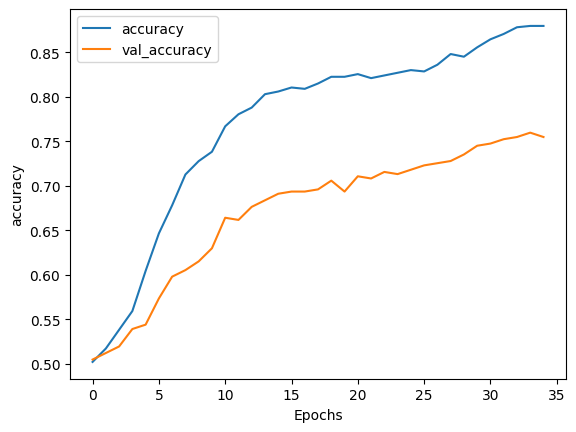

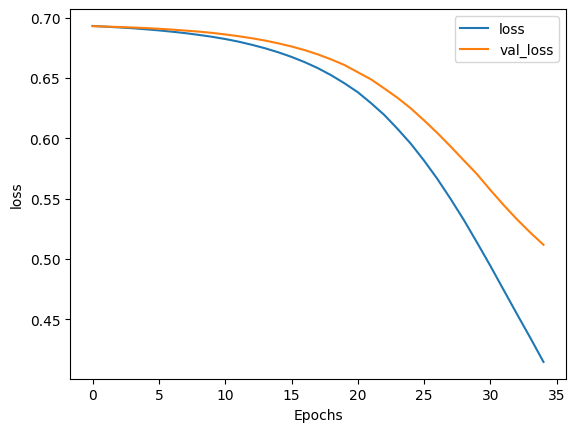

In [22]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Evaluate using test data

In [23]:
score = model.evaluate(test_sentences, test_labels, batch_size=64)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

5/5 [==============================] - 0s 4ms/step - loss: 0.5338 - accuracy: 0.7228

ACCURACY: 0.722806990146637
LOSS: 0.5337896943092346


# Save the Model

In [24]:
model_saved_path = "./models/"
tf.saved_model.save(model, model_saved_path)

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


## made with	&#x1F49D;

 Development : Load Model To Predict Value

In [25]:
new_model = tf.saved_model.load(model_saved_path)

In [26]:
new_model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x297a958af90>

In [27]:
text_to_predict = ["Makanan sangat lezat dan bergizi cocok untuk liburan. Sangat direkomendasikan"]
print(text_to_predict)
prediction = new_model([text_to_predict])
prediction.numpy()[0][0]

['Makanan sangat lezat dan bergizi cocok untuk liburan. Sangat direkomendasikan']


0.8082563